<a href="https://colab.research.google.com/github/engphb/OpenPNM/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use of Hardware Accelerator (GPU) and larger RAM memory at Google Colab


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


# OpenPNM and PoreSpy install

In [3]:
!pip install porespy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install openpnm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing the necessary libraries

In [5]:
import os
import imageio
import scipy as sp
import numpy as np
import openpnm as op
import porespy as ps
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import math
from porespy.tools import randomize_colors
from skimage.morphology import binary_dilation
#ps.visualization.set_mpl_style()
op.visualization.set_mpl_style()
np.set_printoptions(precision=4)

# Download the image of interest from Google Drive

In [6]:
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
! gdown -- 1EZqu96xGjMkLSNPCzjAx_P5pC7RWc3Hi

Downloading...
From: https://drive.google.com/uc?id=1EZqu96xGjMkLSNPCzjAx_P5pC7RWc3Hi
To: /content/poros.tiff
100% 325M/325M [00:01<00:00, 259MB/s]


# Opening the 3D image 

The input Micro-CT image size is: (760, 654, 654)


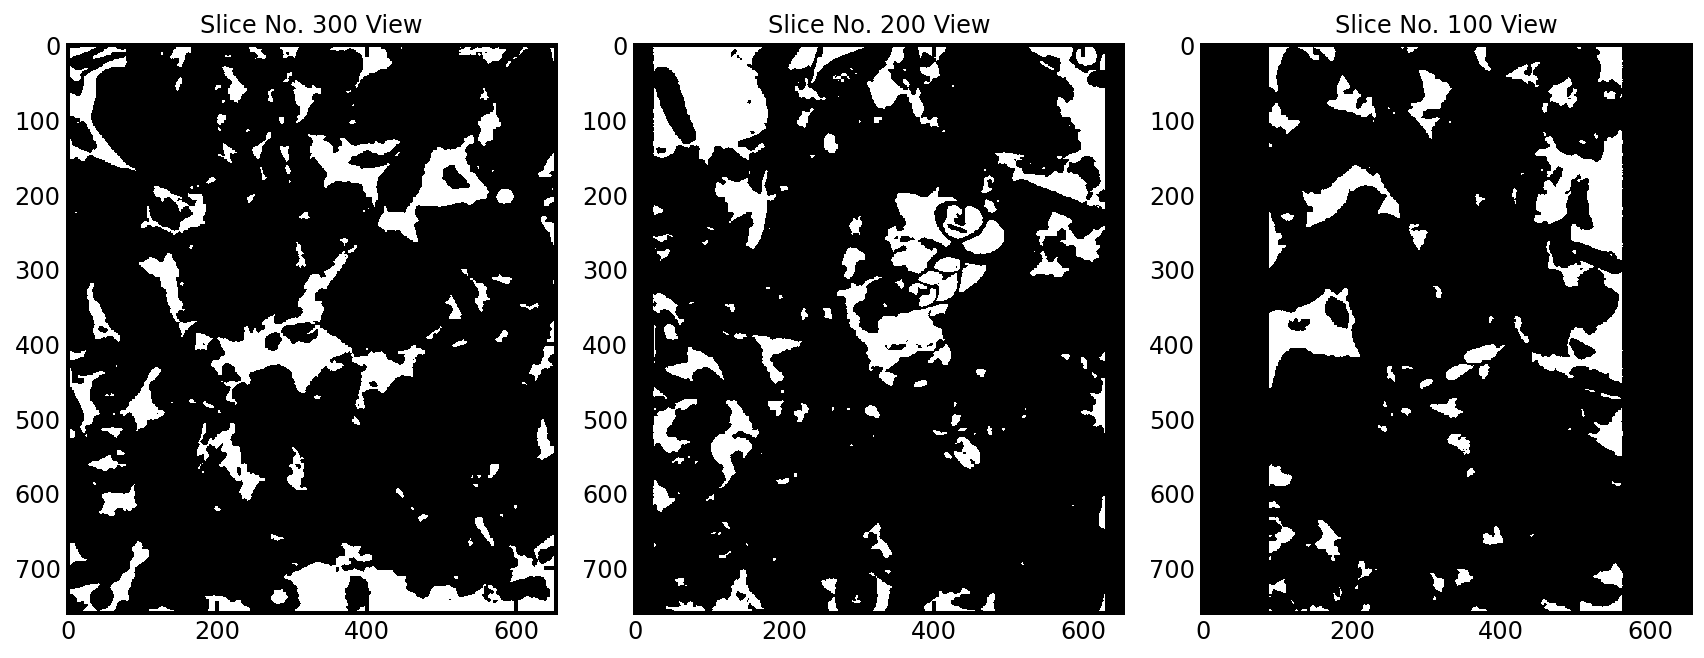

In [8]:
path ='/content/poros.tiff'
file_name = 'pores'
file_format = '.tif'
file = file_name + file_format
image = os.path.join(path, file)
fetch_file = os.path.join(path, file)
im = imageio.mimread('/content/poros.tiff', memtest=False)
im = np.array(im, dtype=bool)
print('The input Micro-CT image size is: {}'.format(im.shape))
fig, ax = plt.subplots(1, 3, figsize=(12,5))
ax[0].imshow(im[:, :, 300],cmap='gray');
ax[0].set_title("Slice No. 300 View");
ax[1].imshow(im[:, :, 200],cmap='gray');
ax[1].set_title("Slice No. 200 View");
ax[2].imshow(im[:, :, 100],cmap='gray');
ax[2].set_title("Slice No. 100 View");

In [9]:
resolution = 12.0511003727059 # voxel size unit in µm
net=ps.networks.snow2(im, voxel_size=resolution, accuracy='standard', sigma=0.4, r_max=4)

A saída de streaming foi truncada nas últimas 5000 linhas.





330it [00:04, 79.99it/s]


378it [00:04, 75.94it/s]




341it [00:04, 66.25it/s]
397it [00:04, 74.89it/s]



377it [00:04, 82.57it/s]

308it [00:04, 57.95it/s]





398it [00:04, 79.61it/s]




366it [00:04, 75.74it/s]


350it [00:04, 70.60it/s]



387it [00:04, 87.17it/s]






339it [00:04, 67.81it/s]
405it [00:04, 66.27it/s]

316it [00:04, 61.40it/s]




359it [00:04, 75.55it/s]


395it [00:04, 74.76it/s]





407it [00:04, 69.12it/s]



396it [00:04, 86.95it/s]

323it [00:04, 61.76it/s]






347it [00:04, 64.25it/s]
412it [00:04, 60.51it/s]


405it [00:04, 80.38it/s]




368it [00:05, 73.60it/s]



405it [00:04, 86.00it/s]





415it [00:04, 66.66it/s]

331it [00:04, 66.24it/s]






357it [00:04, 71.67it/s]
421it [00:04, 66.64it/s]


414it [00:04, 78.95it/s]




394it [00:04, 74.49it/s]





376it [00:05, 67.32it/s]



414it [00:04, 78.73it/s]

338it [00:04, 64.27it/s]






365it [00:04, 70.43it/s]
431it [00:05, 72.

In [10]:
pn = op.io.network_from_porespy(net.network)
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Network at 0x7f6ab5a6f130>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  throat.conns                                                14425 / 14425
  3  pore.coords                                                   9884 / 9884
  4  pore.region_label                                             9884 / 9884
  5  pore.phase                                                    9884 / 9884
  6  throat.phases                                               14425 / 14425
  7  pore.region_volume                                            9884 / 9884
  8  pore.equivalent_diameter                                      9884 / 9884
  9  pore.local_peak                                               9884 / 9884
 

In [12]:
pore_data_sheet = pd.DataFrame({k: pn[k] for k in pn.props(element='pore') if pn[k].ndim == 1})
pore_data_sheet = pore_data_sheet

In [13]:
throat_data_sheet = pd.DataFrame({k: pn[k] for k in pn.props(element='throat') if pn[k].ndim == 1})
throat_data_sheet = throat_data_sheet

In [14]:
pore_data_sheet.describe().round(4)

,pore.equivalent_diameter,pore.extended_diameter,pore.inscribed_diameter,pore.phase,pore.region_label,pore.region_volume,pore.surface_area,pore.volume
count,9884.0000,9884.0000,9884.0000,9884.0,9884.0000,9.884000e+03,9.884000e+03,9.884000e+03
mean,160.7920,131.2826,95.9950,1.0,4942.5000,7.389217e+06,1.249786e+05,7.389217e+06
std,115.2799,104.0437,67.9471,0.0,2853.4094,3.139316e+07,2.605625e+05,3.139316e+07
min,14.9518,24.1022,24.1022,1.0,1.0000,1.750169e+03,-4.792558e+03,1.750169e+03
25%,84.8876,59.0381,48.2044,1.0,2471.7500,3.202810e+05,1.699180e+04,3.202810e+05
50%,130.3106,99.3759,76.2179,1.0,4942.5000,1.158612e+06,4.647329e+04,1.158612e+06
75%,200.4624,163.4691,120.5110,1.0,7413.2500,4.217908e+06,1.215930e+05,4.217908e+06
max,1255.6795,1057.4797,749.1094,1.0,9884.0000,1.036657e+09,5.999411e+06,1.036657e+09


In [15]:
throat_data_sheet.describe().round(4)

,throat.cross_sectional_area,throat.direct_length,throat.equivalent_diameter,throat.inscribed_diameter,throat.perimeter,throat.total_length
count,1.442500e+04,14425.0000,14425.0000,14425.0000,14425.0000,14425.0000
mean,2.094847e+04,276.4777,121.7952,93.5318,505.0794,298.5847
std,5.339656e+04,171.1134,108.8079,79.0273,580.8530,181.4809
min,1.452290e+02,24.4586,13.5982,24.1022,0.0000,27.8240
25%,2.033206e+03,155.0418,50.8798,41.7462,108.4599,169.7132
50%,6.535306e+03,236.2805,91.2196,72.3066,337.4308,255.8607
75%,1.946069e+04,354.0521,157.4107,118.0762,686.9127,380.0136
max,1.690901e+06,1823.6257,1467.2841,1023.7054,10219.3331,1900.1511
